In [1]:
%load_ext autoreload
%autoreload 2
import math
import pprint
from datetime import datetime
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import statsmodels.api as sm
import zipline
from matplotlib import style
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint
from tqdm import tqdm_notebook
from trading_calendars.always_open import AlwaysOpenCalendar

import utils

style.use("ggplot")

In [2]:
COINT_RESEARCH_DATE = pd.Timestamp("2018-08-01")
BTC_MIN = 0.001
BCH_MIN = 0.01
ETH_MIN = 0.01
LTC_MIN = 0.1

# Get Data

In [3]:
BTC_MIN = 0.001
BCH_MIN = 0.01
ETH_MIN = 0.01
LTC_MIN = 0.1
coint_research_data = utils.combine_market_data("candles/", "USD", "open", True, 
                                                file_names_to_exclude=["ZRX-USD.csv", "ETC-USD.csv", "BCH-USD.csv"])
coint_research_data.interpolate(inplace=True, method="linear")
coint_research_data.head()

coint_research_data["ETH-USD"] *= ETH_MIN
coint_research_data["BTC-USD"] *= BTC_MIN
#coint_research_data["BCH-USD"] *= BCH_MIN
coint_research_data["LTC-USD"] *= LTC_MIN

coint_research_data = coint_research_data.apply(lambda x: round(x, 3))

['ETH-USD.csv', 'BTC-USD.csv', 'LTC-USD.csv']


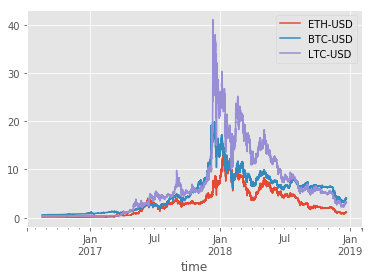

In [4]:
coint_research_data.plot()

In [5]:
pairs_min_weights = {'ETH-USD': ETH_MIN, 'BTC-USD': BTC_MIN, 'BCH-USD': BCH_MIN, 'LTC-USD': LTC_MIN}
backtest_panel = utils.create_zipline_panel("candles/", ('ETH-USD', 'BTC-USD', 'LTC-USD'), 
                                            pairs_min_weights)

/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  This is separate from the ipykernel package so we can avoid doing imports until


# Backtest

In [6]:
all_possible_pairs = list(combinations(['ETH-USD', 'BTC-USD', 'LTC-USD'], 2))
all_possible_pairs

[('ETH-USD', 'BTC-USD'), ('ETH-USD', 'LTC-USD'), ('BTC-USD', 'LTC-USD')]

In [36]:
start_date = datetime(2018, 3, 1, 0, 0, 0, 0, pytz.utc)
end_date = datetime(2018, 11, 15, 0, 0, 0, 0, pytz.utc)
total = (end_date - start_date).days
portfolio_value = []

with tqdm_notebook(total=total) as pbar:
    def initialize(context):
        zipline.api.set_benchmark(zipline.api.symbol("BTC-USD"))
        zipline.api.set_commission(zipline.api.commission.PerShare(cost=0, min_trade_cost=0))
        
        context.window_size = None
        context.half_life_coef = 3
        context.z_score_open_thresholds = [1]
        context.z_score_close = 0
        
        context.coint_weights = None
        context.assets = []
        context.z_score_open = 0
        context.is_closing_positions = False
        context.is_in_betting = False
        
        context.coint_z_scores = None
        zipline.api.schedule_function(daily_update, 
                                      date_rule=zipline.api.date_rules.every_day(),
                                      time_rule=zipline.api.time_rules.market_open(hours=1))
        context.is_look_for_new_pair = True
        context.current_allocation_level = 0
        
    def daily_update(context, data):
        print(f"{zipline.api.get_datetime()}, {zipline.api.get_datetime().weekday()}")
        if zipline.api.get_datetime().day == 1:
            context.is_look_for_new_pair = True
        cur_portfolio_value = context.portfolio.portfolio_value
        #print(f"Current Portfolio Value: {cur_portfolio_value}")
        pbar.update(1)
        
    def choose_pair_for_trading(context, data):
        current_datetime = zipline.api.get_datetime()
        month_ago = current_datetime - pd.Timedelta(days=183)
        print(month_ago, current_datetime)
        selected_data = coint_research_data.loc[:current_datetime]
        
        pairs_p_values = np.empty(shape=len(all_possible_pairs))
        for pair_index, (currency1, currency2) in enumerate(all_possible_pairs):
            pair1, pair2 = selected_data[currency1], selected_data[currency2]
            coint_results = coint(pair1, pair2, maxlag=1)
            pairs_p_values[pair_index] = coint_results[1]
        trading_pair1, trading_pair2 = all_possible_pairs[np.argmin(pairs_p_values)]
        context.assets = [zipline.api.symbol(trading_pair1), zipline.api.symbol(trading_pair2)]
        
        selected_data = coint_research_data.loc[:current_datetime]
        model = OLS(selected_data[trading_pair1], sm.add_constant(selected_data[trading_pair2]))
        ols_results = model.fit()
        context.coint_weights = np.array([1, -ols_results.params[trading_pair2]])
        
        coint_series = selected_data[trading_pair1] - selected_data[trading_pair2] * ols_results.params[trading_pair2] +\
                        ols_results.params["const"]
        
        dependent_var = coint_series.diff()[1:]
        independent_var = coint_series.shift(1)[1:]
        independent_var.name = "val_prev"
        model = OLS(dependent_var, sm.add_constant(independent_var))
        ols_results = model.fit()
        mean_reverse_half_life = -np.log(2) / ols_results.params["val_prev"]
        context.window_size = int(mean_reverse_half_life * context.half_life_coef)
        print(f"New pair for trading {trading_pair1} and {trading_pair2}. Half-life: {mean_reverse_half_life}")
        print(f"p-value: {pairs_p_values.min()} || window size: {context.window_size}")
        print(f"Coint weights: {context.coint_weights}")
        print(pairs_p_values)
        context.is_look_for_new_pair = False
        
        context.coint_z_scores = coint_research_data[[trading_pair1, trading_pair2]]
        context.coint_z_scores *= context.coint_weights
        context.coint_z_scores = context.coint_z_scores.sum(axis=1)
        means = pd.ewma(context.coint_z_scores, span=context.window_size)
        stds = pd.ewmstd(context.coint_z_scores, span=context.window_size)
        context.coint_z_scores = (context.coint_z_scores - means) / stds
        
            
    def order_assets(context, data, is_long, z_score):
        portfolio_weights = data.history(context.assets, "price", 1, "1m").values[0]
        portfolio_weights *= context.coint_weights
        portfolio_weights /= np.absolute(portfolio_weights).sum()
        if not is_long:
            portfolio_weights *= -1
        
        new_level = 0
        for level_index, z_score_level in enumerate(context.z_score_open_thresholds):
            if abs(z_score) >= z_score_level:
                new_level = level_index + 1
            else:
                break
                
        if new_level > context.current_allocation_level:
            print(f"New allocation level {new_level}")
            if z_score > 0:
                print("Shorting")
            else:
                print("Longing")
            portfolio_weights *= (new_level / len(context.z_score_open_thresholds))
            for asset_index, asset in enumerate(context.assets):
                #print(f"Order {asset} {portfolio_weights[asset_index]}")
                zipline.api.order_target_percent(asset, portfolio_weights[asset_index])

            context.z_score_open = z_score
            context.is_in_betting = True
            context.current_allocation_level = new_level
            context.max_portfolio_value = context.portfolio.portfolio_value
        
    def close_positions(context, data):
        for order in zipline.api.get_open_orders():
            zipline.api.cancel_order(order)
            
        for asset in context.portfolio.positions.keys():
            zipline.api.order_target_percent(asset, 0)
        context.position = 0
        context.z_score_open = 0
        context.is_closing_positions = True
        context.current_allocation_level = 0
    
    def handle_data(context, data):
        positions_amount = len(context.portfolio.positions)
        open_orders_amount = len(zipline.api.get_open_orders()) 
        if context.is_look_for_new_pair and positions_amount == 0 and open_orders_amount == 0:
            choose_pair_for_trading(context, data)
        
        cur_portfolio_value = context.portfolio.portfolio_value
        portfolio_value.append(cur_portfolio_value)
        coint_series = data.history(context.assets, "price", 1, "1m")
        coint_series *= context.coint_weights
        coint_series = coint_series.sum(axis=1)
        
        last_value = coint_series[-1]
        if not np.isnan(last_value):
            z_score = context.coint_z_scores.loc[zipline.api.get_datetime()]
            
            positions_value = context.portfolio.positions_value
            #print(z_score, cur_portfolio_value, beta_change)
            
            if positions_amount == 0:
                context.is_closing_positions = False 

            if context.is_closing_positions and positions_amount > 0 and open_orders_amount == 0:
                close_positions(context, data)                
            elif not context.is_closing_positions:
                if z_score > context.z_score_open_thresholds[0] and context.z_score_open >= 0 and open_orders_amount == 0:
                    order_assets(context, data, False, z_score)
                elif z_score < -context.z_score_open_thresholds[0] and context.z_score_open <= 0 and open_orders_amount == 0:
                    order_assets(context, data, True, z_score) 
                elif (context.z_score_open > 0 and z_score <= context.z_score_close) or\
                     (context.z_score_open < 0 and z_score >= -context.z_score_close):
                    print("Closing Positions")
                    close_positions(context, data)

    perfomance = zipline.run_algorithm(start=start_date,
                                   end=end_date,
                                   initialize=initialize,
                                   trading_calendar=AlwaysOpenCalendar(),
                                   handle_data=handle_data,
                                   capital_base=1000,
                                   data_frequency='minute',
                                   data=backtest_panel)

2017-08-30 00:00:00+00:00 2018-03-01 00:00:00+00:00
New pair for trading BTC-USD and LTC-USD. Half-life: 9617.7712220226
p-value: 0.0006072779972701223 || window size: 28853
Coint weights: [ 1.         -0.55072067]
[0.31807894 0.0212934  0.00060728]


/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=28853,min_periods=0,adjust=True,ignore_na=False).mean()
/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: pd.ewm_std is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=28853,min_periods=0,adjust=True,ignore_na=False).std(bias=False)


2018-03-01 00:59:00+00:00, 3
2017-08-30 01:00:00+00:00 2018-03-01 01:00:00+00:00
New pair for trading BTC-USD and LTC-USD. Half-life: 9630.197977142388
p-value: 0.0006247209718474553 || window size: 28890
Coint weights: [ 1.         -0.55068573]
[0.31831644 0.02115355 0.00062472]


/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=28890,min_periods=0,adjust=True,ignore_na=False).mean()
/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: pd.ewm_std is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=28890,min_periods=0,adjust=True,ignore_na=False).std(bias=False)


2018-03-02 00:59:00+00:00, 4


/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


2018-03-03 00:59:00+00:00, 5
2018-03-04 00:59:00+00:00, 6
2018-03-05 00:59:00+00:00, 0
2018-03-06 00:59:00+00:00, 1
2018-03-07 00:59:00+00:00, 2
New allocation level 1
Shorting


/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/empyrical/stats.py:790: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


2018-03-08 00:59:00+00:00, 3
2018-03-09 00:59:00+00:00, 4
Closing Positions
2018-03-10 00:59:00+00:00, 5
2018-03-11 00:59:00+00:00, 6
2018-03-12 00:59:00+00:00, 0
2018-03-13 00:59:00+00:00, 1
2018-03-14 00:59:00+00:00, 2
2018-03-15 00:59:00+00:00, 3
2018-03-16 00:59:00+00:00, 4
2018-03-17 00:59:00+00:00, 5
2018-03-18 00:59:00+00:00, 6
2018-03-19 00:59:00+00:00, 0
New allocation level 1
Shorting
2018-03-20 00:59:00+00:00, 1
2018-03-21 00:59:00+00:00, 2
Closing Positions
2018-03-22 00:59:00+00:00, 3
2018-03-23 00:59:00+00:00, 4
2018-03-24 00:59:00+00:00, 5
2018-03-25 00:59:00+00:00, 6
2018-03-26 00:59:00+00:00, 0
New allocation level 1
Shorting
2018-03-27 00:59:00+00:00, 1
2018-03-28 00:59:00+00:00, 2
2018-03-29 00:59:00+00:00, 3
2018-03-30 00:59:00+00:00, 4
2018-03-31 00:59:00+00:00, 5
2018-04-01 00:59:00+00:00, 6
2018-04-02 00:59:00+00:00, 0
2018-04-03 00:59:00+00:00, 1
Closing Positions
2017-10-02 18:47:00+00:00 2018-04-03 18:47:00+00:00
New pair for trading BTC-USD and LTC-USD. Half-

/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=29955,min_periods=0,adjust=True,ignore_na=False).mean()
/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: pd.ewm_std is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=29955,min_periods=0,adjust=True,ignore_na=False).std(bias=False)


2018-04-04 00:59:00+00:00, 2
2018-04-05 00:59:00+00:00, 3
2018-04-06 00:59:00+00:00, 4
2018-04-07 00:59:00+00:00, 5
2018-04-08 00:59:00+00:00, 6
2018-04-09 00:59:00+00:00, 0
2018-04-10 00:59:00+00:00, 1
2018-04-11 00:59:00+00:00, 2
2018-04-12 00:59:00+00:00, 3
New allocation level 1
Shorting
2018-04-13 00:59:00+00:00, 4
2018-04-14 00:59:00+00:00, 5
2018-04-15 00:59:00+00:00, 6
2018-04-16 00:59:00+00:00, 0
2018-04-17 00:59:00+00:00, 1
Closing Positions
2018-04-18 00:59:00+00:00, 2
2018-04-19 00:59:00+00:00, 3
2018-04-20 00:59:00+00:00, 4
2018-04-21 00:59:00+00:00, 5
2018-04-22 00:59:00+00:00, 6
2018-04-23 00:59:00+00:00, 0
2018-04-24 00:59:00+00:00, 1
2018-04-25 00:59:00+00:00, 2
New allocation level 1
Shorting
2018-04-26 00:59:00+00:00, 3
2018-04-27 00:59:00+00:00, 4
2018-04-28 00:59:00+00:00, 5
2018-04-29 00:59:00+00:00, 6
2018-04-30 00:59:00+00:00, 0
2018-05-01 00:59:00+00:00, 1
2018-05-02 00:59:00+00:00, 2
2018-05-03 00:59:00+00:00, 3
Closing Positions
2017-11-01 13:57:00+00:00 2018

/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=29640,min_periods=0,adjust=True,ignore_na=False).mean()
/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: pd.ewm_std is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=29640,min_periods=0,adjust=True,ignore_na=False).std(bias=False)


2018-05-04 00:59:00+00:00, 4
New allocation level 1
Longing
2018-05-05 00:59:00+00:00, 5
2018-05-06 00:59:00+00:00, 6
2018-05-07 00:59:00+00:00, 0
2018-05-08 00:59:00+00:00, 1
2018-05-09 00:59:00+00:00, 2
Closing Positions
2018-05-10 00:59:00+00:00, 3
2018-05-11 00:59:00+00:00, 4
New allocation level 1
Shorting
2018-05-12 00:59:00+00:00, 5
Closing Positions
2018-05-13 00:59:00+00:00, 6
New allocation level 1
Shorting
Closing Positions
2018-05-14 00:59:00+00:00, 0
2018-05-15 00:59:00+00:00, 1
2018-05-16 00:59:00+00:00, 2
2018-05-17 00:59:00+00:00, 3
2018-05-18 00:59:00+00:00, 4
2018-05-19 00:59:00+00:00, 5
2018-05-20 00:59:00+00:00, 6
2018-05-21 00:59:00+00:00, 0
New allocation level 1
Shorting
2018-05-22 00:59:00+00:00, 1
2018-05-23 00:59:00+00:00, 2
2018-05-24 00:59:00+00:00, 3
Closing Positions
2018-05-25 00:59:00+00:00, 4
2018-05-26 00:59:00+00:00, 5
2018-05-27 00:59:00+00:00, 6
2018-05-28 00:59:00+00:00, 0
New allocation level 1
Shorting
2018-05-29 00:59:00+00:00, 1
Closing Positio

/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=29338,min_periods=0,adjust=True,ignore_na=False).mean()
/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: pd.ewm_std is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=29338,min_periods=0,adjust=True,ignore_na=False).std(bias=False)


2018-06-03 00:59:00+00:00, 6
New allocation level 1
Longing
Closing Positions
2018-06-04 00:59:00+00:00, 0
2018-06-05 00:59:00+00:00, 1
New allocation level 1
Shorting
2018-06-06 00:59:00+00:00, 2
2018-06-07 00:59:00+00:00, 3
2018-06-08 00:59:00+00:00, 4
2018-06-09 00:59:00+00:00, 5
2018-06-10 00:59:00+00:00, 6
Closing Positions
New allocation level 1
Longing
Closing Positions
2018-06-11 00:59:00+00:00, 0
New allocation level 1
Longing
Closing Positions
2018-06-12 00:59:00+00:00, 1
New allocation level 1
Shorting
2018-06-13 00:59:00+00:00, 2
2018-06-14 00:59:00+00:00, 3
2018-06-15 00:59:00+00:00, 4
2018-06-16 00:59:00+00:00, 5
2018-06-17 00:59:00+00:00, 6
2018-06-18 00:59:00+00:00, 0
2018-06-19 00:59:00+00:00, 1
2018-06-20 00:59:00+00:00, 2
2018-06-21 00:59:00+00:00, 3
2018-06-22 00:59:00+00:00, 4
2018-06-23 00:59:00+00:00, 5
2018-06-24 00:59:00+00:00, 6
2018-06-25 00:59:00+00:00, 0
2018-06-26 00:59:00+00:00, 1
2018-06-27 00:59:00+00:00, 2
2018-06-28 00:59:00+00:00, 3
2018-06-29 00:59:

/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=32819,min_periods=0,adjust=True,ignore_na=False).mean()
/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: pd.ewm_std is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=32819,min_periods=0,adjust=True,ignore_na=False).std(bias=False)


2018-08-05 00:59:00+00:00, 6
2018-08-06 00:59:00+00:00, 0
2018-08-07 00:59:00+00:00, 1
2018-08-08 00:59:00+00:00, 2
2018-08-09 00:59:00+00:00, 3
2018-08-10 00:59:00+00:00, 4
2018-08-11 00:59:00+00:00, 5
2018-08-12 00:59:00+00:00, 6
2018-08-13 00:59:00+00:00, 0
2018-08-14 00:59:00+00:00, 1
2018-08-15 00:59:00+00:00, 2
2018-08-16 00:59:00+00:00, 3
2018-08-17 00:59:00+00:00, 4
2018-08-18 00:59:00+00:00, 5
2018-08-19 00:59:00+00:00, 6
2018-08-20 00:59:00+00:00, 0
2018-08-21 00:59:00+00:00, 1
2018-08-22 00:59:00+00:00, 2
New allocation level 1
Shorting
2018-08-23 00:59:00+00:00, 3
2018-08-24 00:59:00+00:00, 4
2018-08-25 00:59:00+00:00, 5
2018-08-26 00:59:00+00:00, 6
2018-08-27 00:59:00+00:00, 0
2018-08-28 00:59:00+00:00, 1
2018-08-29 00:59:00+00:00, 2
2018-08-30 00:59:00+00:00, 3
2018-08-31 00:59:00+00:00, 4
2018-09-01 00:59:00+00:00, 5
2018-09-02 00:59:00+00:00, 6
2018-09-03 00:59:00+00:00, 0
2018-09-04 00:59:00+00:00, 1
2018-09-05 00:59:00+00:00, 2
Closing Positions
2018-03-07 00:19:00+00

/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=37588,min_periods=0,adjust=True,ignore_na=False).mean()
/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: pd.ewm_std is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=37588,min_periods=0,adjust=True,ignore_na=False).std(bias=False)


2018-09-06 00:59:00+00:00, 3
2018-09-07 00:59:00+00:00, 4
2018-09-08 00:59:00+00:00, 5
2018-09-09 00:59:00+00:00, 6
2018-09-10 00:59:00+00:00, 0
2018-09-11 00:59:00+00:00, 1
2018-09-12 00:59:00+00:00, 2
2018-09-13 00:59:00+00:00, 3
2018-09-14 00:59:00+00:00, 4
2018-09-15 00:59:00+00:00, 5
2018-09-16 00:59:00+00:00, 6
2018-09-17 00:59:00+00:00, 0
2018-09-18 00:59:00+00:00, 1
2018-09-19 00:59:00+00:00, 2
2018-09-20 00:59:00+00:00, 3
2018-09-21 00:59:00+00:00, 4
2018-09-22 00:59:00+00:00, 5
2018-09-23 00:59:00+00:00, 6
2018-09-24 00:59:00+00:00, 0
2018-09-25 00:59:00+00:00, 1
New allocation level 1
Longing
2018-09-26 00:59:00+00:00, 2
2018-09-27 00:59:00+00:00, 3
2018-09-28 00:59:00+00:00, 4
2018-09-29 00:59:00+00:00, 5
2018-09-30 00:59:00+00:00, 6
2018-10-01 00:59:00+00:00, 0
2018-10-02 00:59:00+00:00, 1
2018-10-03 00:59:00+00:00, 2
Closing Positions
2018-04-03 03:21:00+00:00 2018-10-03 03:21:00+00:00
New pair for trading BTC-USD and LTC-USD. Half-life: 13704.33286032321
p-value: 0.00083

/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=41112,min_periods=0,adjust=True,ignore_na=False).mean()
/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: pd.ewm_std is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=41112,min_periods=0,adjust=True,ignore_na=False).std(bias=False)


2018-10-04 00:59:00+00:00, 3
2018-10-05 00:59:00+00:00, 4
2018-10-06 00:59:00+00:00, 5
2018-10-07 00:59:00+00:00, 6
2018-10-08 00:59:00+00:00, 0
2018-10-09 00:59:00+00:00, 1
2018-10-10 00:59:00+00:00, 2
2018-10-11 00:59:00+00:00, 3
New allocation level 1
Longing
Closing Positions
2018-10-12 00:59:00+00:00, 4
2018-10-13 00:59:00+00:00, 5
2018-10-14 00:59:00+00:00, 6
2018-10-15 00:59:00+00:00, 0
New allocation level 1
Shorting
2018-10-16 00:59:00+00:00, 1
2018-10-17 00:59:00+00:00, 2
2018-10-18 00:59:00+00:00, 3
2018-10-19 00:59:00+00:00, 4
2018-10-20 00:59:00+00:00, 5
2018-10-21 00:59:00+00:00, 6
2018-10-22 00:59:00+00:00, 0
2018-10-23 00:59:00+00:00, 1
2018-10-24 00:59:00+00:00, 2
2018-10-25 00:59:00+00:00, 3
2018-10-26 00:59:00+00:00, 4
2018-10-27 00:59:00+00:00, 5
2018-10-28 00:59:00+00:00, 6
2018-10-29 00:59:00+00:00, 0
2018-10-30 00:59:00+00:00, 1
2018-10-31 00:59:00+00:00, 2
2018-11-01 00:59:00+00:00, 3
2018-11-02 00:59:00+00:00, 4
2018-11-03 00:59:00+00:00, 5
2018-11-04 00:59:00+

/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=45818,min_periods=0,adjust=True,ignore_na=False).mean()
/Users/nialeksandrov/virtualenvs/zipline_backtest/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: pd.ewm_std is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=45818,min_periods=0,adjust=True,ignore_na=False).std(bias=False)


New allocation level 1
Longing
2018-11-05 00:59:00+00:00, 0
Closing Positions
2018-11-06 00:59:00+00:00, 1
2018-11-07 00:59:00+00:00, 2
2018-11-08 00:59:00+00:00, 3
2018-11-09 00:59:00+00:00, 4
2018-11-10 00:59:00+00:00, 5
2018-11-11 00:59:00+00:00, 6
2018-11-12 00:59:00+00:00, 0
New allocation level 1
Shorting
2018-11-13 00:59:00+00:00, 1
2018-11-14 00:59:00+00:00, 2
Closing Positions
New allocation level 1
Longing
2018-11-15 00:59:00+00:00, 3



Algorithm Period Return: 0.022061301349947327
Aglorithm Period Volatility: 0.1294112938342242
Benchmark Period Return: -0.3747938294363049
Benchmark Period Volatility: 0.5520600829219817


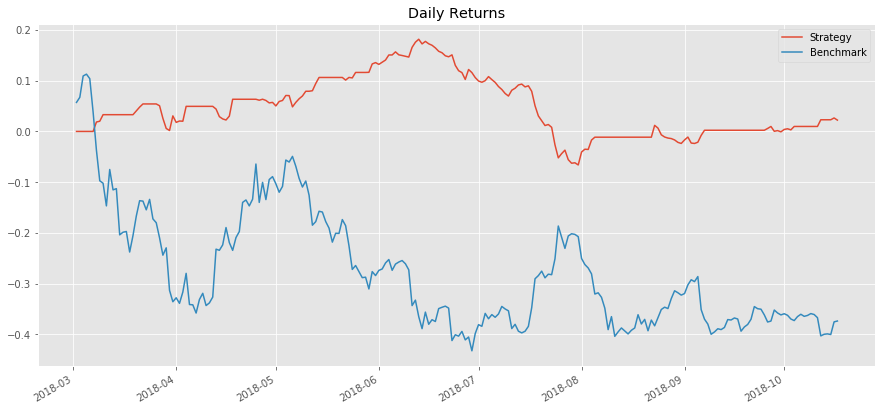

In [37]:
plt.figure(figsize=(15, 7))
plt.title("Daily Returns")
perfomance.algorithm_period_return[:-30].plot(label="Strategy")
perfomance.benchmark_period_return[:-30].plot(label="Benchmark")

print("Algorithm Period Return:", perfomance.algorithm_period_return[-30])
print("Aglorithm Period Volatility:", perfomance.algo_volatility[-30])
print("Benchmark Period Return:", perfomance.benchmark_period_return[-30])
print("Benchmark Period Volatility:", perfomance.benchmark_volatility[-30])
plt.legend();

In [38]:
print("Alpha:", perfomance.alpha[-30])
print("Beta:", perfomance.beta[-30])
print("Max Drawdown:", perfomance.max_drawdown[-30])
print("Sortino:", perfomance.sortino[-30])

Alpha: 0.011566552673341049
Beta: -0.05726793460597798
Max Drawdown: -0.20958522076923342
Sortino: 0.3611967861845048


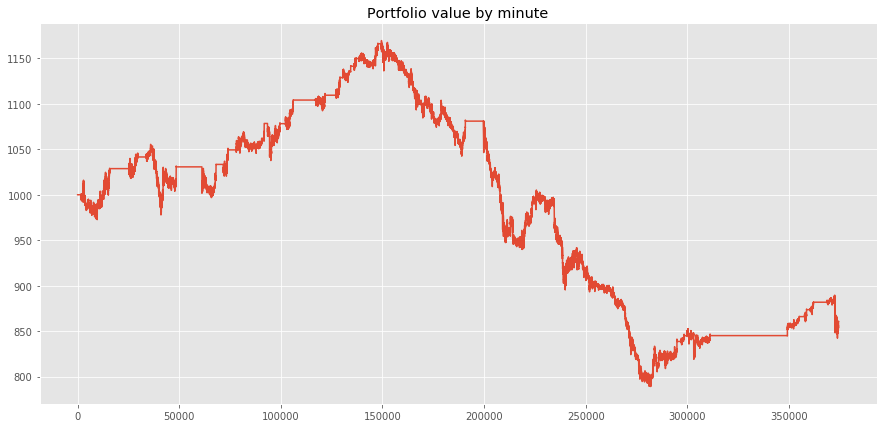

In [30]:
plt.figure(figsize=(15, 7))
plt.title("Portfolio value by minute")
plt.plot(portfolio_value)

Sharpe Ratio: 0.2279960813687808


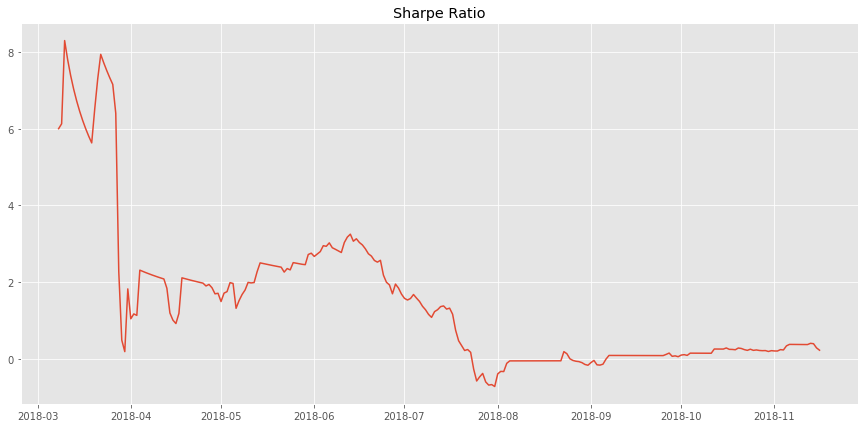

In [39]:
plt.figure(figsize=(15, 7))
plt.title("Sharpe Ratio")
plt.plot(perfomance.sharpe)
print("Sharpe Ratio:", perfomance.sharpe[-1])

In [76]:
1.52

1.52

In [22]:
perfomance.algorithm_period_return.corr(perfomance.benchmark_period_return)

-0.044896901350185994